# Домашнее задание 1. Autoencoders & Frechet Inception Distance


В этом домашнем задании вам предлагается вспомнить то, что происходило на семинарах 1-2, написать свой автоэнкодер на CIFAR10 и использовать эмбеддинги от этого автоэнкодера чтобы посчитать Frechet Inception Distance (FID) между разными классами в CIFAR10

In [3]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from sklearn.ensemble import GradientBoostingClassifier
from collections import defaultdict
import seaborn as sns
from torch.nn import functional as F

Будем использовать torchvision для работы с данными.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x * 2) - 1
])

In [3]:
train_dataset = datasets.CIFAR10(
    './cifar',
    train=True,
    transform=transform,
    download=True)
val_dataset = datasets.CIFAR10(
    './cifar',
    train=False,
    transform=transform,
    download=True)
len(train_dataset), len(val_dataset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

Раз мы используем нормализацию картинок, то чтобы их нарисовать - надо их обратно разнормализировать

In [4]:
def denormalize_image(image):
    return (image + 1) / 2

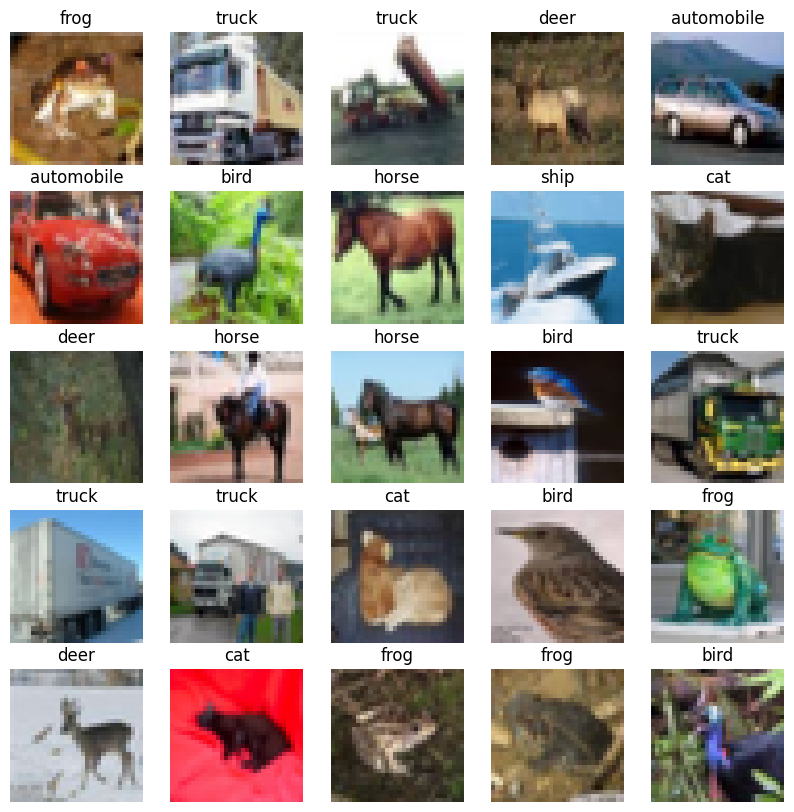

In [5]:
text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(train_dataset):
    plt.subplot(5, 5, index + 1)
    plt.imshow(denormalize_image(image.permute(1, 2, 0)))
    plt.axis('off')
    plt.title(text_labels[label])
    if index == 24: break
plt.show()

Размерность картинок: 3 канала 32х32 пикселя

In [6]:
image.shape

torch.Size([3, 32, 32])

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
len(train_loader), len(val_loader)

(1563, 10000)

### Задание 1. Обучить AE (3 балла)

Постройте свой AE, можете использовать любые блоки которые вам кажутся необходимыми.

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=500>

Напишите классы Encoder и Decoder

хинт: вам пригодятся nn.AvgPool2d/nn.MaxPool2d/Conv2d в энкодере и nn.Upsample/nn.ConvTranspose2d в декодере

In [8]:
class Block(nn.Module):
    def __init__(self, in_features, out_features, kernel_size=4, stride=2, upsample=False, skip = False):
        super().__init__()
        if upsample:
            self.conv = nn.ConvTranspose2d(in_features, out_features, kernel_size, stride, padding=(kernel_size - 1) // 2, bias=False)
        else:
            self.conv = nn.Conv2d(in_features, out_features, kernel_size, stride, padding=(kernel_size - 1) // 2, bias=False)
        self.skip = skip
        self.upsamle = upsample
        self.batch_norm = nn.BatchNorm2d(out_features)
        self.relu = nn.GELU()
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        out = self.conv(x)
        out = 0.95 * out + 0.05 * torch.rand_like(out)
        out = self.dropout(out)
        return self.relu(self.batch_norm(out))

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            Block(3, 12),
            Block(12, 12),
            Block(12, 24), 
            Block(24, 24).conv, 
            )
    def forward(self, x):
        return self.encoder(x)

In [10]:
encoder = Encoder()
noise = torch.rand(1, 3, 32, 32) - 1
assert encoder(noise).view(-1).shape < torch.Size([1*3*32*32])

In [11]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            Block(24, 24, upsample=True),
            Block(24, 12, upsample=True), 
            Block(12, 12, upsample=True), 
            Block(12, 3, upsample=True).conv
            )
        self.tanh = nn.Tanh()
    def forward(self, x):
        x = self.decoder(x)
        return self.tanh(x)

In [12]:
decoder = Decoder()
noise = torch.rand(1, 3, 32, 32)
emb = encoder(noise)
assert decoder(emb).shape == (1, 3, 32, 32)

Посчитаем скор классификации картинок по эмбеддингам необученного энкодора, и в конце сравним с обученным. Для ускорения расчета, мы используем только часть трейна.

In [13]:
def classification_score(encoder, _train_dataset, val_dataset, device):
    encoder.eval()
    torch.manual_seed(0)
    train_dataset = Subset(_train_dataset, torch.randperm(len(_train_dataset))[:5000])
    X_train = []
    y_train = []
    for image, label in tqdm(train_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_train.append(emb.cpu().numpy().reshape(-1))
        y_train.append(label)
    X_train = np.stack(X_train)
    y_train = np.stack(y_train)
    clf = GradientBoostingClassifier(n_estimators=50, max_depth=5, verbose=1, random_state=0)
    clf.fit(X_train, y_train)
    X_val = []
    y_val = []
    for image, label in tqdm(val_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_val.append(emb.cpu().numpy().reshape(-1))
        y_val.append(label)
    X_val = np.stack(X_val)
    y_val = np.stack(y_val)
    return clf.score(X_val, y_val)

In [14]:
classification_score(Encoder(), train_dataset, val_dataset, 'cpu')

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.1835            1.04m
         2           2.0940            1.02m
         3           2.0136            1.00m
         4           1.9440           58.93s
         5           1.8772           57.52s
         6           1.8177           56.24s
         7           1.7645           54.99s
         8           1.7167           53.77s
         9           1.6686           52.48s
        10           1.6185           51.10s
        20           1.2807           38.38s
        30           1.0815           25.72s
        40           0.9213           12.91s
        50           0.7921            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.2439

In [15]:
device = 'cuda:0' if torch.cuda.is_available() else 'mps'
device

'mps'

In [16]:
encoder.to(device)
decoder.to(device)

Decoder(
  (decoder): Sequential(
    (0): Block(
      (conv): ConvTranspose2d(24, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): GELU(approximate='none')
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Block(
      (conv): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): GELU(approximate='none')
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (2): Block(
      (conv): ConvTranspose2d(12, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): GELU(approximate='none')
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (3): ConvTranspose2d(12, 3, kernel_

In [17]:
params = list(encoder.parameters()) + list(decoder.parameters())
optim = torch.optim.AdamW(params)

Напишите функцию train, которая обучает энкодер и декодер на всем трейн сете, возвращает среднюю MSE ошибку

In [18]:
def train(loader, optim, encoder, decoder, device):
    encoder.train()
    decoder.train()
    losses = []
    for image, _ in tqdm(loader, leave=False):
        optim.zero_grad()
        image = image.to(device)
        output = decoder(encoder(image))
        loss = nn.MSELoss()(image, output)
        loss.backward()
        optim.step()
        losses.append(loss.item())
    return sum(losses) / len(losses)

In [19]:
loss = train(train_loader, optim, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/1563 [00:00<?, ?it/s]

0.07654906101214985

Напишите функцию eval, которая возвращает среднюю MSE ошибку по всему валидационному сету

хинт: не забывайте отключать расчет градиентов

In [20]:
@torch.no_grad()
def eval(loader, encoder, decoder, device):
    encoder.eval()
    decoder.eval()
    losses = []
    for image, _ in tqdm(loader, leave=False):
        image = image.to(device)
        ouput = decoder(encoder(image))
        loss = nn.MSELoss()(image, ouput)
        losses.append(loss.item())
    return sum(losses) / len(losses)

In [21]:
loss = eval(val_loader, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/10000 [00:00<?, ?it/s]

0.043022386262193325

Функция full_train возвращает обученный энкодер и декодер. Чтобы пройти ограничения по времени, обучите модель, а затем добавьте загрузку предобученных весов в самое начало функции. Можете использовать шаблон для загрузки весов из Google Drive.

In [22]:
def full_train(device, train_loader, val_loader):
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)
    params = list(encoder.parameters()) + list(decoder.parameters())
    optim = torch.optim.AdamW(params)
    train_loss = []
    val_loss = []
    n_epochs = 30
    for e in trange(n_epochs):
        e_train_loss = train(train_loader, optim, encoder, decoder, device)
        train_loss.append(e_train_loss)
        e_val_loss = eval(val_loader, encoder, decoder, device)
        val_loss.append(e_val_loss)
        print(f'Epoch: {e+1}/{n_epochs}')
        print(f'Train MSE loss: {e_train_loss:.4f}')
        print(f'Validation MSE loss: {e_val_loss:.4f}')
    torch.save(encoder.state_dict(), 'encoder.pt')
    torch.save(decoder.state_dict(), 'decoder.pt')
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.legend()
    plt.title('MSE Loss')
    plt.show()
    return encoder, decoder

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 1/30
Train MSE loss: 0.0801
Validation MSE loss: 0.0503


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 2/30
Train MSE loss: 0.0536
Validation MSE loss: 0.0393


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 3/30
Train MSE loss: 0.0498
Validation MSE loss: 0.0388


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 4/30
Train MSE loss: 0.0472
Validation MSE loss: 0.0360


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 5/30
Train MSE loss: 0.0457
Validation MSE loss: 0.0347


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 6/30
Train MSE loss: 0.0446
Validation MSE loss: 0.0343


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 7/30
Train MSE loss: 0.0441
Validation MSE loss: 0.0332


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 8/30
Train MSE loss: 0.0437
Validation MSE loss: 0.0331


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 9/30
Train MSE loss: 0.0435
Validation MSE loss: 0.0324


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 10/30
Train MSE loss: 0.0432
Validation MSE loss: 0.0322


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 11/30
Train MSE loss: 0.0430
Validation MSE loss: 0.0321


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 12/30
Train MSE loss: 0.0429
Validation MSE loss: 0.0322


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 13/30
Train MSE loss: 0.0426
Validation MSE loss: 0.0320


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 14/30
Train MSE loss: 0.0425
Validation MSE loss: 0.0323


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 15/30
Train MSE loss: 0.0423
Validation MSE loss: 0.0325


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 16/30
Train MSE loss: 0.0424
Validation MSE loss: 0.0320


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 17/30
Train MSE loss: 0.0422
Validation MSE loss: 0.0318


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 18/30
Train MSE loss: 0.0422
Validation MSE loss: 0.0323


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 19/30
Train MSE loss: 0.0421
Validation MSE loss: 0.0318


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 20/30
Train MSE loss: 0.0420
Validation MSE loss: 0.0324


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 21/30
Train MSE loss: 0.0419
Validation MSE loss: 0.0319


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 22/30
Train MSE loss: 0.0419
Validation MSE loss: 0.0319


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 23/30
Train MSE loss: 0.0417
Validation MSE loss: 0.0334


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 24/30
Train MSE loss: 0.0418
Validation MSE loss: 0.0333


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 25/30
Train MSE loss: 0.0416
Validation MSE loss: 0.0321


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 26/30
Train MSE loss: 0.0415
Validation MSE loss: 0.0327


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 27/30
Train MSE loss: 0.0415
Validation MSE loss: 0.0317


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 28/30
Train MSE loss: 0.0415
Validation MSE loss: 0.0318


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 29/30
Train MSE loss: 0.0414
Validation MSE loss: 0.0320


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 30/30
Train MSE loss: 0.0414
Validation MSE loss: 0.0319


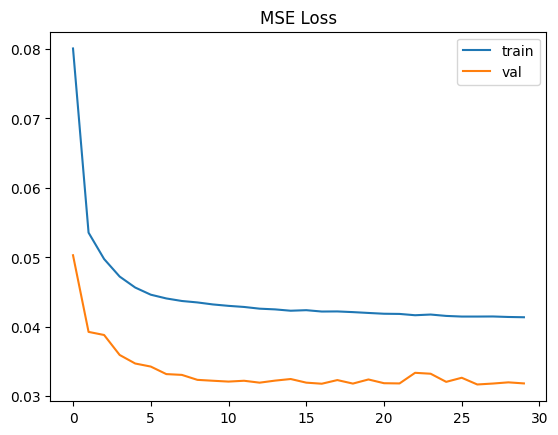

In [23]:
encoder, decoder = full_train(device, train_loader, val_loader)

In [4]:
score = classification_score(encoder, train_dataset, val_dataset, device)
assert score > 0.39
score

0.3971

на самом деле этот скор -- это такой рандом. типа если перезапустить это, то спокойно можно получить 0.37, а можно и чуть больше.

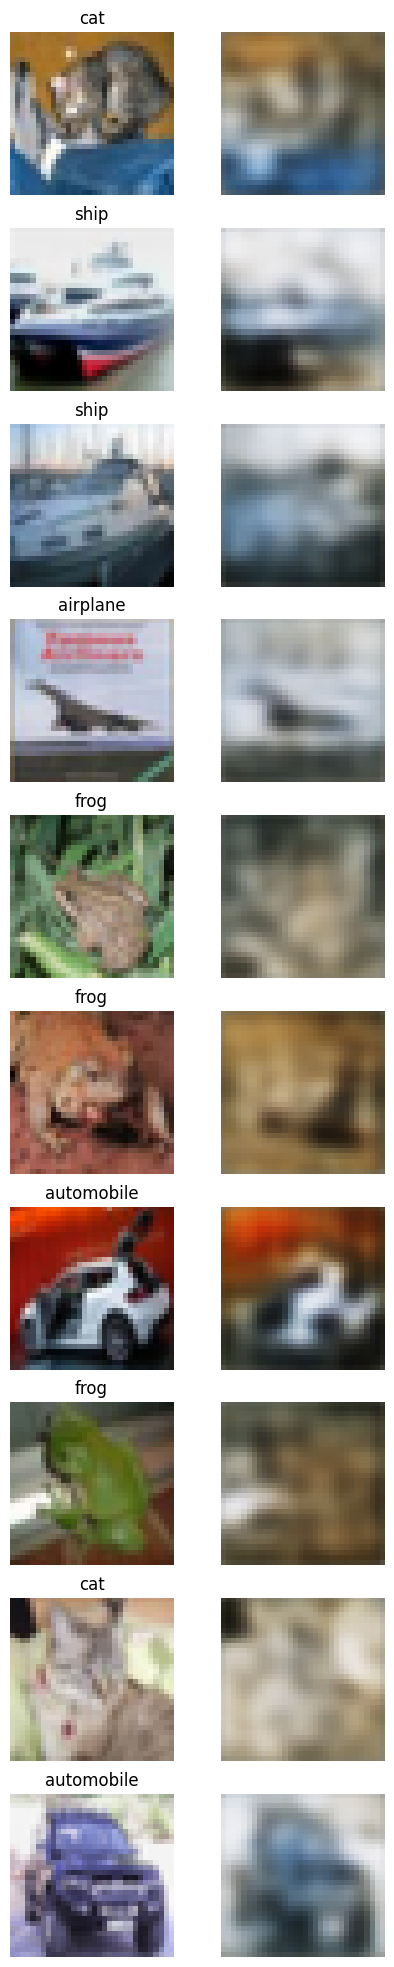

In [25]:
encoder.eval()
decoder.eval()
plt.figure(figsize=(5, 25))
for index, (image, label) in enumerate(val_loader):
    plt.subplot(10, 2, index*2+1)
    plt.imshow(denormalize_image(image)[0].permute(1, 2, 0))
    plt.axis('off')
    plt.title(text_labels[label])
    plt.subplot(10, 2, index*2+2)
    image = image.to(device)
    with torch.no_grad():
        emb = encoder(image)
        rec = decoder(emb).cpu()
    plt.imshow(denormalize_image(rec)[0].permute(1, 2, 0))
    plt.axis('off')
    if index == 9: break

### Задание 2. FID дистанция между классами CIFAR10 (3 балла)

В этой части хочется чтобы вы, используя bottleneck репрезентации от AE обученного в прошлой части посчитали FID дистанцию между различными классами CIFAR10 на **валидационной** выборке

За копию кода из сети будем снимать баллы

Напишите функцию get_representations, которая возвращает defaultdict, где ключ — это номер класса, значение — это список эмбеддингов, полученных из энкодера.

In [162]:
@torch.no_grad()
def get_representations(dataloader, encoder, device):
    encoder.eval()
    representations = defaultdict(list)
    for x, y in tqdm(dataloader):
        x = x.to(device)
        representations[y.item()].append(encoder(x)[0])
    return representations

In [163]:
representations = get_representations(val_loader, encoder, device)
assert len(representations) == 10
assert len(representations[0]) == 1000
assert type(representations[0][0]) == torch.Tensor
# assert representations[0][0].shape == (256, )

  0%|          | 0/10000 [00:00<?, ?it/s]

Напишите функцию расчета FID
$$\text{FID}=\left\|\mu_{r}-\mu_{g}\right\|^{2}+T_{r}\left(\Sigma_{r}+\Sigma_{g}-2\left(\Sigma_{r} \Sigma_{g}\right)^{1 / 2}\right)$$

In [164]:
# сначала не обратил внимания на то, что в следующей ячейке numpy...
import numpy as np
from scipy.linalg import sqrtm

def calculate_fid(repr1, repr2):
    mu1 = np.mean(repr1, axis=0)
    mu2 = np.mean(repr2, axis=0)

    cov1 = np.cov(repr1.T)
    cov2 = np.cov(repr2.T)

    sqrt_cov = sqrtm(cov1 @ cov2)

    return np.linalg.norm(mu1 - mu2) ** 2 + np.real(np.trace(cov1 + cov2 - 2 * sqrt_cov))

In [165]:
heatmap = np.zeros((10, 10))
for label_from in trange(10):
    for label_to in range(10):
        fid = calculate_fid(
            torch.stack(representations[label_from], dim=0).cpu().numpy(),
            torch.stack(representations[label_to], dim=0).cpu().numpy()
        )
        heatmap[label_from, label_to] = fid
assert heatmap.shape == (10, 10)
assert np.all(heatmap + 1e-5 > 0)
airplane_ship = heatmap[0, 8]
airplane_frog = heatmap[0, 6]
truck_automobile = heatmap[9, 1]
truck_dog = heatmap[9, 5]
assert airplane_ship < airplane_frog
assert truck_automobile < truck_dog

  0%|          | 0/10 [00:00<?, ?it/s]

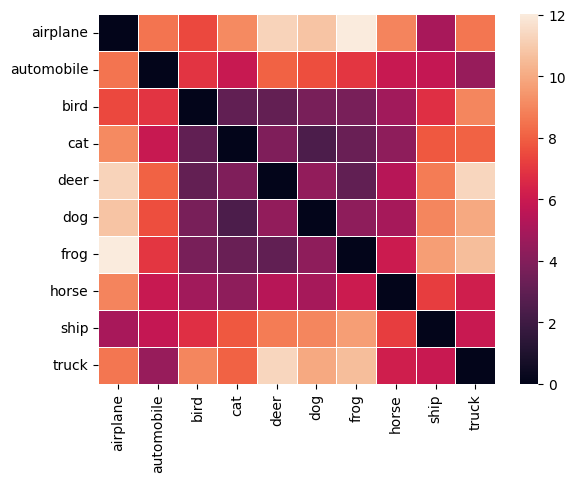

In [166]:
sns.heatmap(
    heatmap, 
    linewidth=0.5, 
    xticklabels=text_labels, 
    yticklabels=text_labels
)
plt.show()

## Задание 3 (3 балла)

Выберите ваш любимый датасет с кошками и собаками и посчитайте FID между двумя классами на новых данных, используя репрезентацию с уже обученного AE

хинт: если любимого датасета с кошками и собаками нет, можно вырезать эти классы из имажнета

хинт: если вам оооочень не нравятся кошки и собаки, то можете выбрать другие два противоположных класса

In [167]:
import os
import pathlib
from typing import List, Dict, Tuple
from PIL import Image
import torch
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
    
    @classmethod
    def find_classes(cls, directory: str) -> Tuple[List[str], Dict[str, int]]:
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx
    
    def __init__(self, targ_dir:str, transform=None):
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = self.find_classes(targ_dir)
        
    def load_img(self, index: int) -> Image.Image:
        img_path = self.paths[index]
        return Image.open(img_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_img(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx
        

transform = transform = transforms.Compose([
    transforms.Resize(size=(32, 32)),
    transforms.ToTensor(),
    lambda x: (x * 2) - 1
])
data_custom=ImageFolderCustom(targ_dir='dog_and_cats/test_set',transform=transform)
dataloader=DataLoader(dataset=data_custom,batch_size=1,shuffle=True,num_workers=0)

In [168]:
representations = get_representations(dataloader, encoder, device)

  0%|          | 0/2023 [00:00<?, ?it/s]

In [169]:
heatmap = np.zeros((2, 2))
for label_from in trange(2):
    for label_to in range(2):
        fid = calculate_fid(
            torch.stack(representations[label_from], dim=0).cpu().numpy(),
            torch.stack(representations[label_to], dim=0).cpu().numpy()
        )
        heatmap[label_from, label_to] = fid

  0%|          | 0/2 [00:00<?, ?it/s]

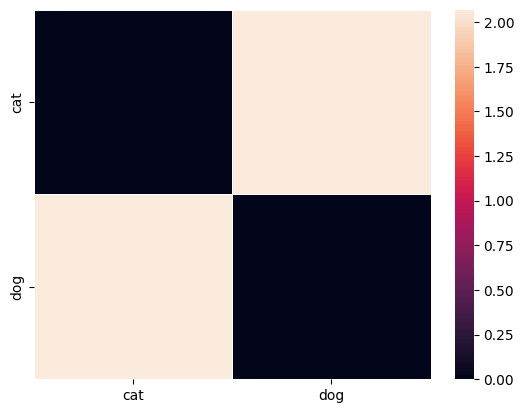

In [170]:
sns.heatmap(
    heatmap, 
    linewidth=0.5, 
    xticklabels=['cat', 'dog'], 
    yticklabels=['cat', 'dog']
)
plt.show()

## Задание 4 (1 балл)

Вы отлично поработали и, скорее всего, в процессе выполнения этих задач у вас появились идеи о том, как еще можно решать подобные проблемы. 

Здесь вы можете описать способы которые вам хотелось бы попробовать если бы у вас было больше времени, или показать статьи которые вы читали, которые решают такие задачи.

Дополнительно, необходимо приложить сюда какой-нибудь смешной мем про генеративные модели за последние два года. Если мем будет не смешным, то баллы придется снять.

Не очень понятно, что имеется в виду под данной проблемой. Если то, что FID показал, что распределения котиков и собачек достаточно близки, то тут проблема в слабом encoder. Можно взять что-то обученное на условном imagenet, и получать латентные вектора как выход последнего свёрточного слоя. Как показывает практика, это очень хороший способ.

Также можно попробывать что-то типа image retriveal: ну то есть опять же извлекать признаки с помощью предобученной CNN, а дальше искать ближайшие с помощью $\ell_2$-distance или cosine similarity.

Мем не про генеративные модели и ему чуть больше 2 лет(всё-таки mixer вышел в 21 году), но мне он всё равно очень нравится)))

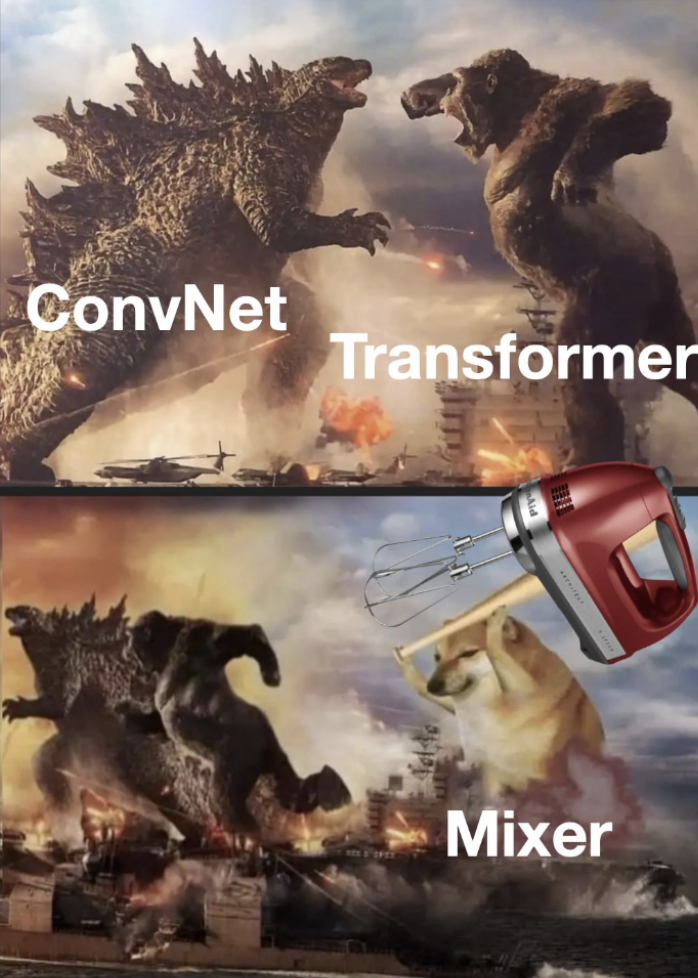
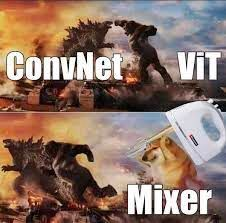